# Libraries

In [1]:
# numpy
import numpy as np

# pandas
import pandas as pd

# matplotlib
import matplotlib.pyplot as plt
# settings
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large', titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

# CNN
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.image import convert_image_dtype
from tensorflow.data.experimental import AUTOTUNE
from keras.applications import VGG16
from tensorflow.keras.layers import RandomContrast, RandomFlip, RandomTranslation
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# evaluation
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Data

In [2]:
# convert image from uint8 to float32
def convert_to_float(image, label):
  image = convert_image_dtype(image, dtype=tf.float32)
  return image, label

# get the matrix of the categorical affiliation of pictures (from train/valid/test sets)
def get_labels_from_tfdataset(tfdataset, batched=False):
  all_labels = [] # the matrix
  for _, labels in tfdataset: # for every batch of pictures get the matrix (batch_size x the number of categories) that represents whether given picture (row) belongs (1) or doesn't belong (0) to a category
    all_labels.append(labels.numpy())
  if not batched:
      return tf.concat(all_labels, axis=0) # concatenate to have the (the number of pictures x the number of categories) matrix
  return all_labels

# data import (and labelling)
train_images = image_dataset_from_directory(
  directory='./dataset/train',
  labels='inferred', # generated based on the directory structure
  label_mode='categorical', # encoding of labels - in this case: categorical vector
  image_size=[224, 224], # resizing the images to the given shape
  interpolation='nearest', # the interpolation type while resizing
  batch_size=32, # the number of images loaded at the same time
  shuffle=True, # randomize images
)

valid_images = image_dataset_from_directory(
  directory='./dataset/valid',
  labels='inferred', # generated based on the directory structure
  label_mode='categorical', # encoding of labels - in this case: categorical vector
  image_size=[224, 224], # resizing the images to the given shape
  interpolation='nearest', # the interpolation type while resizing
  batch_size=32, # the number of images loaded at the same time
  shuffle=True, # randomize images
)

test_images = image_dataset_from_directory(
  directory='./dataset/test',
  labels='inferred', # generated based on the directory structure
  label_mode='categorical', # encoding of labels - in this case: categorical vector
  image_size=[224, 224], # resizing the images to the given shape
  interpolation='nearest', # the interpolation type while resizing
  batch_size=32, # the number of images loaded at the same time
  shuffle=True, # randomize images
)

# get the names of clasess
train_class_names = train_images.class_names
valid_class_names = valid_images.class_names
test_class_names = test_images.class_names

# convert the images to float
train_images = (
  train_images
  .map(convert_to_float) # mapping
  .cache() # use cache to speed up iterations
  .prefetch(buffer_size=AUTOTUNE) # prefetch the new batch while the earlier one is still being processed
)

valid_images = (
  valid_images
  .map(convert_to_float) # mapping
  .cache() # use cache to speed up iterations
  .prefetch(buffer_size=AUTOTUNE) # prefetch the new batch while the earlier one is still being processed
)

test_images = (
  test_images
  .map(convert_to_float) # mapping
  .cache() # use cache to speed up iterations
  .prefetch(buffer_size=AUTOTUNE) # prefetch the new batch while the earlier one is still being processed
)

# distributions of the pictures based on the given classes
train_categorical_affilation = get_labels_from_tfdataset(train_images)
train_categories_indexes = np.argmax(train_categorical_affilation, axis=1) # get "the index of the category" for each row
_, train_category_len = np.unique(train_categories_indexes, return_counts=True) # count the number of pictures that belong to the given categories
train_pieces_distr = pd.DataFrame(data=np.asarray((train_class_names, train_category_len)).T, columns=["Category", "Count"]) # creating the table
print("Train dataset")
display(train_pieces_distr) # showing the table
print("\n")

valid_categorical_affilation = get_labels_from_tfdataset(valid_images)
valid_categories_indexes = np.argmax(valid_categorical_affilation, axis=1) # get "the index of the category" for each row
_, valid_category_len = np.unique(valid_categories_indexes, return_counts=True) # count the number of pictures that belong to the given categories
valid_pieces_distr = pd.DataFrame(data=np.asarray((valid_class_names, valid_category_len)).T, columns=["Category", "Count"]) # creating the table
print("Valid dataset")
display(valid_pieces_distr) # showing the table
print("\n")

test_categorical_affilation = get_labels_from_tfdataset(test_images)
test_categories_indexes = np.argmax(test_categorical_affilation, axis=1) # get "the index of the category"
_, test_category_len = np.unique(test_categories_indexes, return_counts=True) # count the number of pictures that belong to the given categories
test_pieces_distr = pd.DataFrame(data=np.asarray((test_class_names, test_category_len)).T, columns=["Category", "Count"]) # creating the table
print("Test dataset")
display(test_pieces_distr) # showing the table
print("\n")

Found 2493 files belonging to 13 classes.
Found 831 files belonging to 13 classes.
Found 826 files belonging to 13 classes.
Train dataset


,Category,Count
0,black_bishop,192
1,black_king,192
2,black_knight,192
3,black_pawn,191
4,black_queen,192
5,black_rook,192
6,empty_tile,192
7,white_bishop,192
8,white_king,192
9,white_knight,192




Valid dataset


,Category,Count
0,black_bishop,64
1,black_king,64
2,black_knight,64
3,black_pawn,63
4,black_queen,64
5,black_rook,64
6,empty_tile,64
7,white_bishop,64
8,white_king,64
9,white_knight,64




Test dataset


,Category,Count
0,black_bishop,64
1,black_king,63
2,black_knight,64
3,black_pawn,61
4,black_queen,63
5,black_rook,64
6,empty_tile,64
7,white_bishop,64
8,white_king,64
9,white_knight,64


# Model

In [3]:
pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # use 'imagenet' weights in CNN and delete the fully-connected layers
pretrained_model.summary()
pretrained_model.trainable = False # do not train any layer

# the head of the model (the last layers)
model = tf.keras.Sequential([
    # data augmentation
    RandomContrast(factor=0.5),
    RandomFlip(mode='horizontal'),
    RandomTranslation(height_factor=0.1, width_factor=0.1),
    # base model
    pretrained_model,
    # the head
    # block 1
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    # block 2
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.GlobalMaxPooling2D(),
    layers.Dropout(0.4),
    # output
    layers.BatchNormalization(),
    layers.Dense(13, activation='softmax'),
])

early_stopping = EarlyStopping(
    min_delta = 0.001,           # min improvement
    patience = 30,               # epochs to wait before stopping
    restore_best_weights = True, # the weights corresponding with the lowest validation loss
)

optimizer = tf.keras.optimizers.Adam(epsilon=0.001)

# compile
model.compile(
    optimizer= optimizer,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

# Training

In [4]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_images,
        validation_data= valid_images,
        epochs= 200,
        callbacks=[early_stopping],
       )
model.save("model_cnn.keras")

Epoch 1/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - categorical_accuracy: 0.6718 - loss: 1.0954 - val_categorical_accuracy: 0.5740 - val_loss: 1.7009
Epoch 2/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - categorical_accuracy: 0.9835 - loss: 0.0763 - val_categorical_accuracy: 0.8303 - val_loss: 1.0861
Epoch 3/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - categorical_accuracy: 0.9894 - loss: 0.0532 - val_categorical_accuracy: 0.9615 - val_loss: 0.4089
Epoch 4/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - categorical_accuracy: 0.9970 - loss: 0.0223 - val_categorical_accuracy: 0.9868 - val_loss: 0.1738
Epoch 5/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - categorical_accuracy: 0.9955 - loss: 0.0215 - val_categorical_accuracy: 0.9892 - val_loss: 0.0686
Epoch 6/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - categorical_accuracy: 0.9989 - loss: 0.0114 - val_categorical_accuracy: 0.9916 - val_loss: 0.0539
Epoch 7/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - categorical_accuracy: 0.9968 - los

# Evaluation

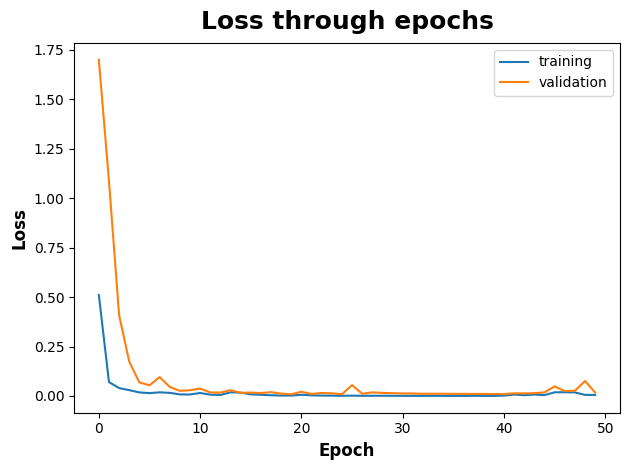

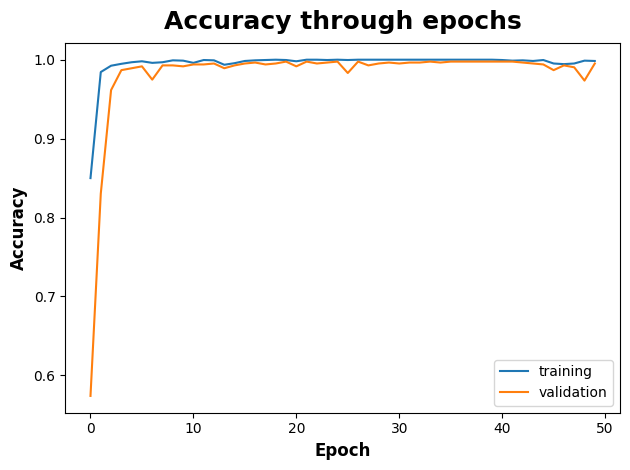

Metrics of the model with chosen parameters


,categorical_accuracy,loss,val_categorical_accuracy,val_loss
19,0.999599,0.002033,0.997593,0.008683


78/78 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step


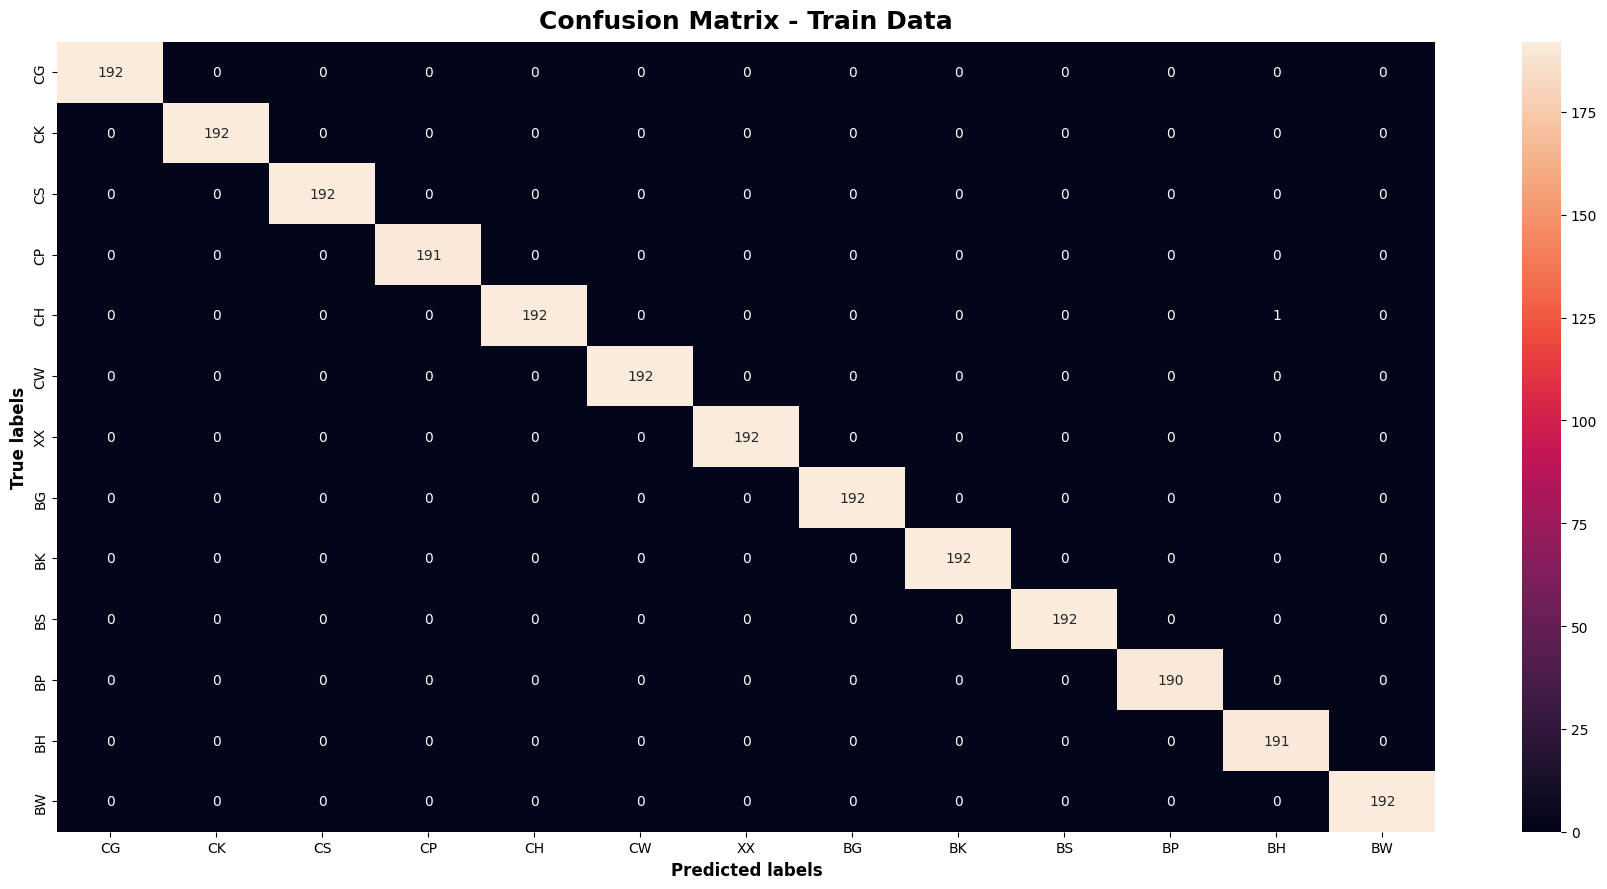

['CG = black bishop', 'CK = black king', 'CS = black knight', 'CP = black pawn', 'CH = black queen', 'CW = black rook', 'XX = empty tile', 'BG = white bishop', 'BK = white king', 'BS = white knight', 'BP = white pawn', 'BH = white queen', 'BW = white rook']
              precision    recall  f1-score   support

black bishop     1.0000    1.0000    1.0000       192
  black king     1.0000    1.0000    1.0000       192
black knight     1.0000    1.0000    1.0000       192
  black pawn     1.0000    1.0000    1.0000       191
 black queen     1.0000    0.9948    0.9974       193
  black rook     1.0000    1.0000    1.0000       192
  empty tile     1.0000    1.0000    1.0000       192
white bishop     1.0000    1.0000    1.0000       192
  white king     1.0000    1.0000    1.0000       192
white knight     1.0000    1.0000    1.0000       192
  white pawn     1.0000    1.0000    1.0000       190
 white queen     0.9948    1.0000    0.9974       191
  white rook     1.0000    1.0000    1.

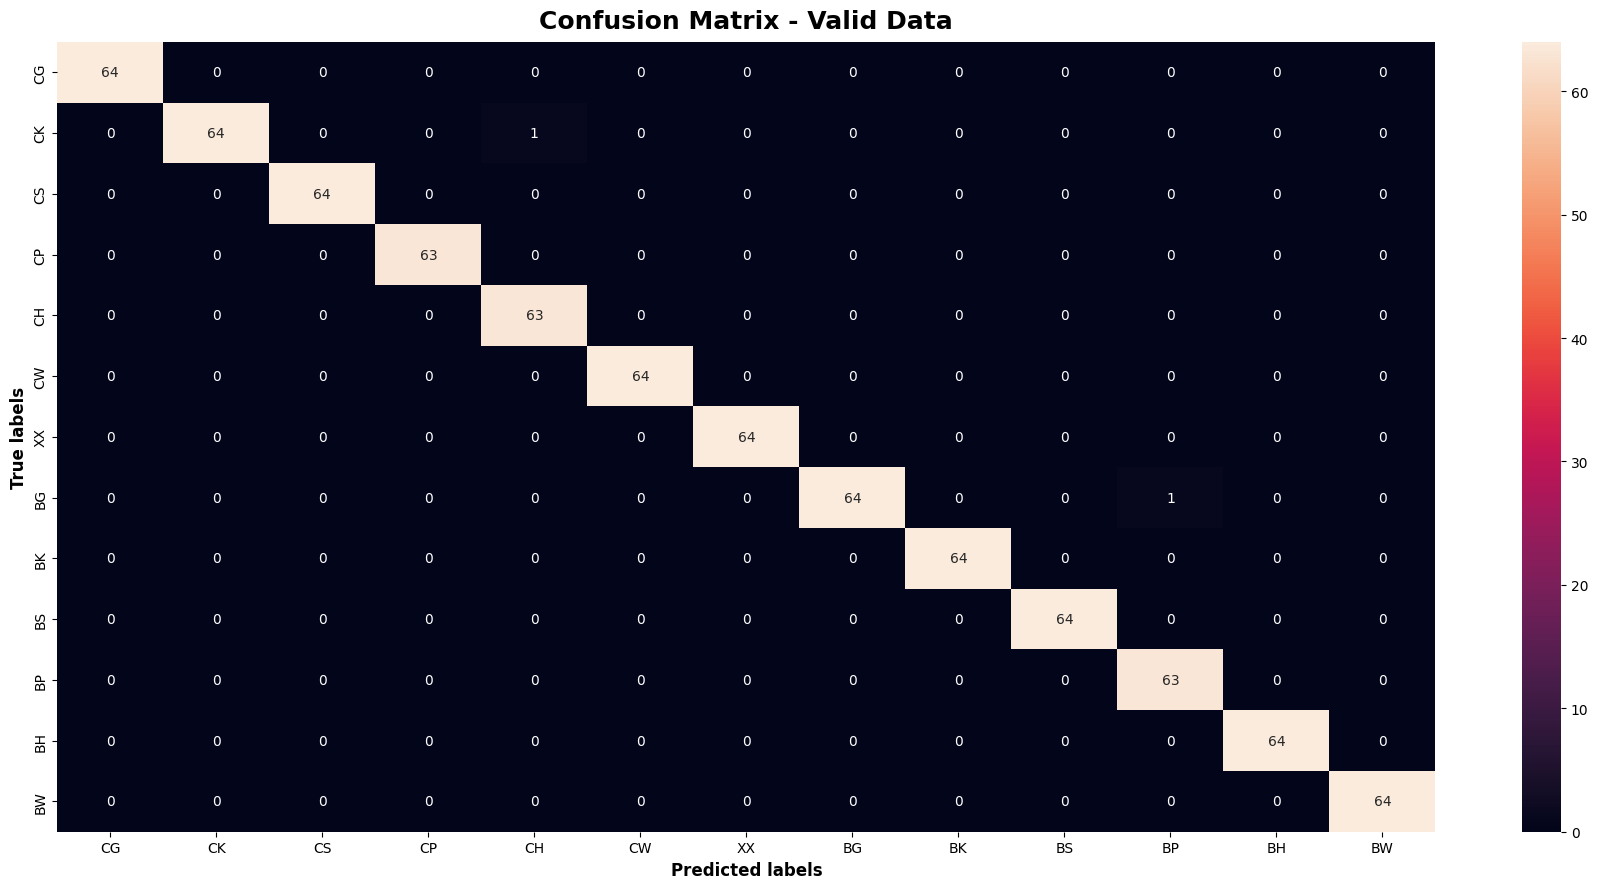

['CG = black bishop', 'CK = black king', 'CS = black knight', 'CP = black pawn', 'CH = black queen', 'CW = black rook', 'XX = empty tile', 'BG = white bishop', 'BK = white king', 'BS = white knight', 'BP = white pawn', 'BH = white queen', 'BW = white rook']
              precision    recall  f1-score   support

black bishop     1.0000    1.0000    1.0000        64
  black king     1.0000    0.9846    0.9922        65
black knight     1.0000    1.0000    1.0000        64
  black pawn     1.0000    1.0000    1.0000        63
 black queen     0.9844    1.0000    0.9921        63
  black rook     1.0000    1.0000    1.0000        64
  empty tile     1.0000    1.0000    1.0000        64
white bishop     1.0000    0.9846    0.9922        65
  white king     1.0000    1.0000    1.0000        64
white knight     1.0000    1.0000    1.0000        64
  white pawn     0.9844    1.0000    0.9921        63
 white queen     1.0000    1.0000    1.0000        64
  white rook     1.0000    1.0000    1.

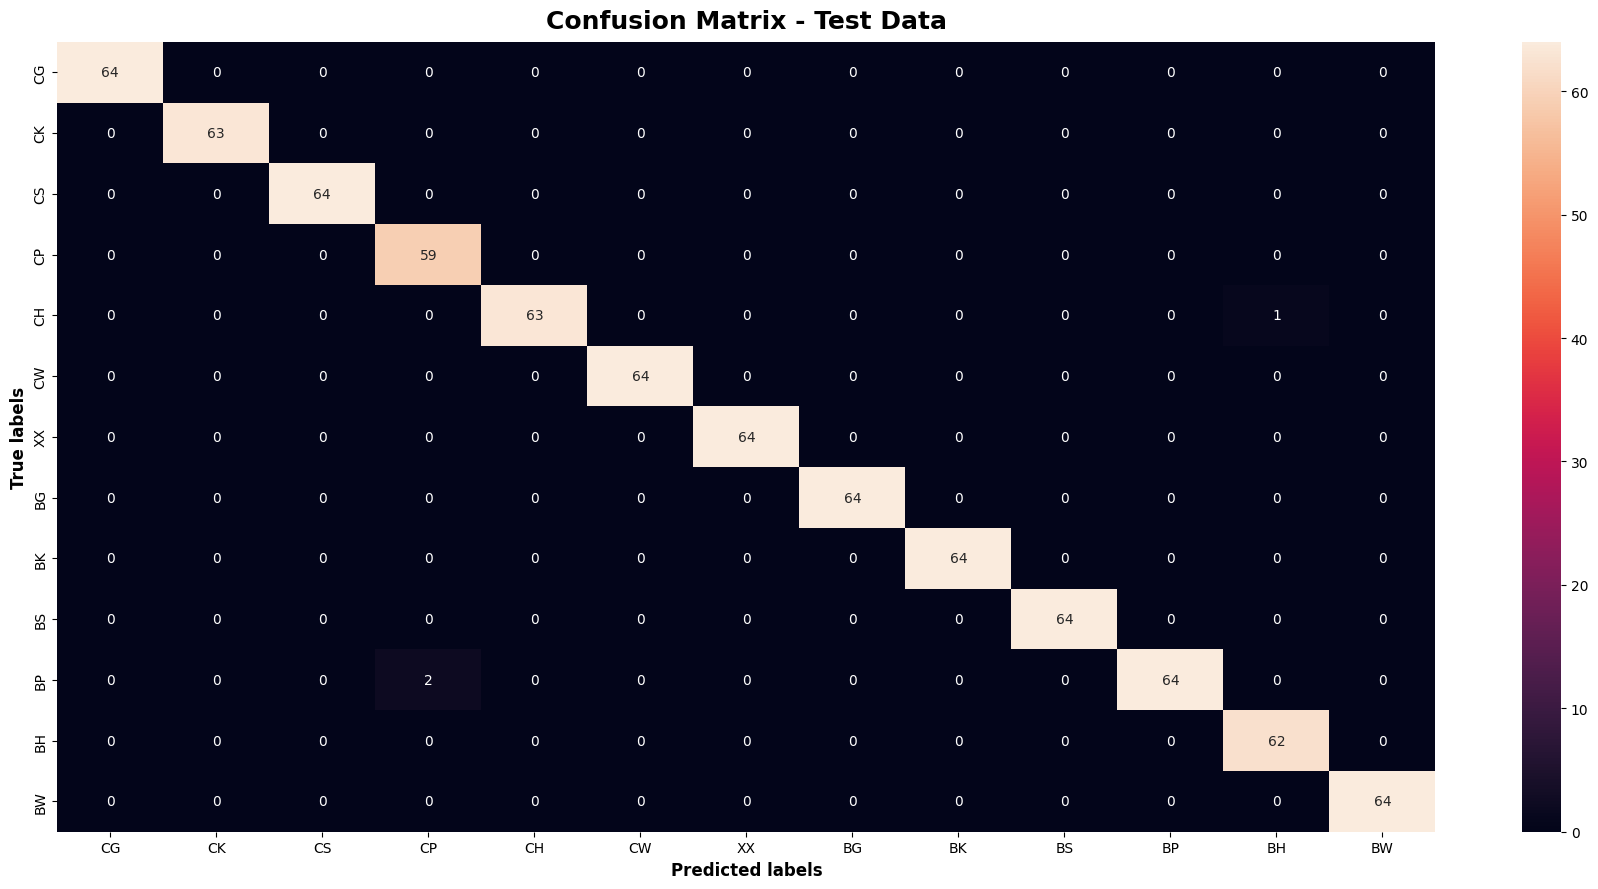

['CG = black bishop', 'CK = black king', 'CS = black knight', 'CP = black pawn', 'CH = black queen', 'CW = black rook', 'XX = empty tile', 'BG = white bishop', 'BK = white king', 'BS = white knight', 'BP = white pawn', 'BH = white queen', 'BW = white rook']
              precision    recall  f1-score   support

black bishop     1.0000    1.0000    1.0000        64
  black king     1.0000    1.0000    1.0000        63
black knight     1.0000    1.0000    1.0000        64
  black pawn     0.9672    1.0000    0.9833        59
 black queen     1.0000    0.9844    0.9921        64
  black rook     1.0000    1.0000    1.0000        64
  empty tile     1.0000    1.0000    1.0000        64
white bishop     1.0000    1.0000    1.0000        64
  white king     1.0000    1.0000    1.0000        64
white knight     1.0000    1.0000    1.0000        64
  white pawn     1.0000    0.9697    0.9846        66
 white queen     0.9841    1.0000    0.9920        62
  white rook     1.0000    1.0000    1.

In [5]:
# data based on the model learning path
history_frame = pd.DataFrame(history.history)

# plotting loss
history_frame.loc[:, ['loss', 'val_loss']].plot() # plot the data
plt.title('Loss through epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'])
plt.show()

# plotting accurancy
history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot(); # plot the data
plt.title('Accuracy through epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'])
plt.show()

# metrics of the model with chosen parameters
print("Metrics of the model with chosen parameters")
display(history_frame[history_frame.val_loss == history_frame.val_loss.min()])

target_names = ["black bishop", "black king", "black knight",
                "black pawn", "black queen", "black rook",
                "empty tile", "white bishop", "white king",
                "white knight", "white pawn", "white queen",
                "white rook"]

# the real labels of the pictures
y_real_train = get_labels_from_tfdataset(train_images)
y_real_train = np.argmax(y_real_train, axis=1)

# the predicted labels of the pictures
y_pred_train_prob = model.predict(train_images)
y_pred_train = np.argmax(y_pred_train_prob, axis=1)

# the confusion matrix for the train set
cm_train = confusion_matrix(y_pred_train, y_real_train)

plt.figure(figsize=(18, 9))
ax_train = plt.subplot()
sns.heatmap(cm_train, annot=True, fmt='g', ax=ax_train); # annot - write the number of times the given combination occured in the cells, fmt - the format of the annotations ('g' - to disable scientific notation)
ax_train.set_xlabel('Predicted labels');
ax_train.set_ylabel('True labels');
ax_train.set_title('Confusion Matrix - Train Data');
ax_train.xaxis.set_ticklabels(["CG", "CK", "CS", "CP", "CH", "CW", "XX", "BG", "BK", "BS", "BP", "BH", "BW"]);
ax_train.yaxis.set_ticklabels(["CG", "CK", "CS", "CP", "CH", "CW", "XX", "BG", "BK", "BS", "BP", "BH", "BW"]);
plt.show()

# legend
print(["CG = black bishop", "CK = black king", "CS = black knight",
                "CP = black pawn", "CH = black queen", "CW = black rook",
                "XX = empty tile", "BG = white bishop", "BK = white king",
                "BS = white knight", "BP = white pawn", "BH = white queen",
                "BW = white rook"])

# the classifcation report on the train set
print(classification_report(y_pred_train, y_real_train, target_names = target_names, digits = 4))

# the overall accuracy of the model on the train set
print("Total accuracy on the train set: ", accuracy_score(y_pred_train, y_real_train))

# the real labels of the pictures
y_real_valid = get_labels_from_tfdataset(valid_images)
y_real_valid = np.argmax(y_real_valid, axis=1)

# the predicted labels of the pictures
y_pred_valid_prob = model.predict(valid_images)
y_pred_valid = np.argmax(y_pred_valid_prob, axis=1)

# the confusion matrix for the valid set
cm_valid = confusion_matrix(y_pred_valid, y_real_valid)

plt.figure(figsize=(18, 9))
ax_valid = plt.subplot()
sns.heatmap(cm_valid, annot=True, fmt='g', ax=ax_valid); # annot - write the number of times the given combination occured in the cells, fmt - the format of the annotations ('g' - to disable scientific notation)
ax_valid.set_xlabel('Predicted labels');
ax_valid.set_ylabel('True labels');
ax_valid.set_title('Confusion Matrix - Valid Data');
ax_valid.xaxis.set_ticklabels(["CG", "CK", "CS", "CP", "CH", "CW", "XX", "BG", "BK", "BS", "BP", "BH", "BW"]);
ax_valid.yaxis.set_ticklabels(["CG", "CK", "CS", "CP", "CH", "CW", "XX", "BG", "BK", "BS", "BP", "BH", "BW"]);
plt.show()

# legend
print(["CG = black bishop", "CK = black king", "CS = black knight",
                "CP = black pawn", "CH = black queen", "CW = black rook",
                "XX = empty tile", "BG = white bishop", "BK = white king",
                "BS = white knight", "BP = white pawn", "BH = white queen",
                "BW = white rook"])

# the classifcation report on the valid set
print(classification_report(y_pred_valid, y_real_valid, target_names = target_names, digits = 4))

# the overall accuracy of the model on the valid set
print("Total accuracy on the valid set: ", accuracy_score(y_pred_valid, y_real_valid))

# the real labels of the pictures
y_real_test = get_labels_from_tfdataset(test_images)
y_real_test = np.argmax(y_real_test, axis=1)

# the predicted labels of the pictures
y_pred_test_prob = model.predict(test_images)
y_pred_test = np.argmax(y_pred_test_prob, axis=1)

# the confusion matrix for the test set
cm_test = confusion_matrix(y_pred_test, y_real_test)

plt.figure(figsize=(18, 9))
ax_test = plt.subplot()
sns.heatmap(cm_test, annot=True, fmt='g', ax=ax_test); # annot - write the number of times the given combination occured in the cells, fmt - the format of the annotations ('g' - to disable scientific notation)
ax_test.set_xlabel('Predicted labels');
ax_test.set_ylabel('True labels');
ax_test.set_title('Confusion Matrix - Test Data');
ax_test.xaxis.set_ticklabels(["CG", "CK", "CS", "CP", "CH", "CW", "XX", "BG", "BK", "BS", "BP", "BH", "BW"]);
ax_test.yaxis.set_ticklabels(["CG", "CK", "CS", "CP", "CH", "CW", "XX", "BG", "BK", "BS", "BP", "BH", "BW"]);
plt.show()

# legend
print(["CG = black bishop", "CK = black king", "CS = black knight",
                "CP = black pawn", "CH = black queen", "CW = black rook",
                "XX = empty tile", "BG = white bishop", "BK = white king",
                "BS = white knight", "BP = white pawn", "BH = white queen",
                "BW = white rook"])

# the classifcation report on the test set
print(classification_report(y_pred_test, y_real_test, target_names = target_names, digits = 4))

# the overall accuracy of the model on the test set
print("Total accuracy on the test set: ", accuracy_score(y_pred_test, y_real_test))

# References

Source: Detecting Chess Pieces with a CNN (Kaggle) (https://www.kaggle.com/code/thomassvisser/detecting-chess-pieces-with-a-cnn)